In [29]:
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, date, time, timedelta

# Read in the TJs data set
tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Player", "TJ Surgery Date"])

# clean up the tommy john data by dropping Nulls and changing the 
tommy_johns = tommy_johns.dropna(how = 'all')
tommy_johns['Player'] = tommy_johns['Player'].apply(lambda x: ', '.join(x.split()[::-1]))
tommy_johns['TJ Surgery Date'] = pd.to_datetime(tommy_johns['TJ Surgery Date'])


# Reads in multiple data sets for pitch velocity and pitch spin rate then concats all the data together
pitch_velocity = pd.read_csv('pitch_velocity_1.csv', usecols = ["player_name", "velocity", "api_game_date_month_text", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('pitch_velocity_' + str(i) + '.csv', usecols = ["player_name", "velocity", "api_game_date_month_text", "year"])
    pitch_velocity = pd.concat([pitch_velocity, temp_pd], ignore_index = True)

spin_rate = pd.read_csv('spin_rate_1.csv', usecols = ["player_name", "pitch_percent", "api_game_date_month_text", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('spin_rate_' + str(i) + '.csv', usecols = ["player_name", "pitch_percent", "api_game_date_month_text", "year"])
    spin_rate = pd.concat([spin_rate, temp_pd], ignore_index = True)

pitcher_data = pd.merge(pitch_velocity, spin_rate, how = 'left', left_on = ['player_name', 'api_game_date_month_text', 'year'],
                                                                right_on = ['player_name', 'api_game_date_month_text', 'year'])
pitcher_data = pitcher_data.dropna(subset = ['pitch_percent'])


# Creates a mapping for turning a str month into a int month
month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar/Apr': '03',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep/Oct': '09',
    'Nov': '11',
    'Dec': '12'
}

# Uses map above to turn a dataframe from str months into a int months
def replace_month(date_str):
    for month_str, month_num in month_map.items():
        date_str = date_str.replace(month_str, month_num)
    return date_str

# Turns the months in the aggregated pitcher data into numbers not strings
pitcher_data['api_game_date_month_text'] = pitcher_data['api_game_date_month_text'].apply(replace_month)


# Merges the two data sets together and turns the date of when someone got a TJ into a 1
result = pd.merge(pitcher_data, tommy_johns, how = 'left', left_on = ['player_name'], right_on = ['Player'])
result['TJ'] = result['TJ Surgery Date'].notna().astype(int)

# Gets rid of the data after someone got a TJ
temp = result[result['TJ Surgery Date'].dt.year >= result['year']]

# Adds together the data where after the TJ it doesn't matter and if someone never got a TJ
result2 = result[result['TJ'] == 0]
final_result = pd.concat([result2, temp], ignore_index = True)

# Aggregates all the data for a specific player taking the mean of the velocity, TJ (Either 0 or 1 so mean shouldnt change), and spin rate
final_result = result.groupby(['player_name'], as_index = False)[['TJ', 'velocity', 'pitch_percent']].mean()

# Runs a logistic Regression on the data with TJ being the y variable
model = sm.Logit(final_result['TJ'], final_result[['velocity', 'pitch_percent']]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.604516
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     TJ   No. Observations:                 2893
Model:                          Logit   Df Residuals:                     2891
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 May 2024   Pseudo R-squ.:               -0.002369
Time:                        07:46:02   Log-Likelihood:                -1748.9
converged:                       True   LL-Null:                       -1744.7
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
velocity         -0.0085      0.001     -7.934      0.000      -0.011      -0.006
pitch_percent    -0.0034      0.003     -1.064      0.287      -0.010       0.003
=================================================================================
"""

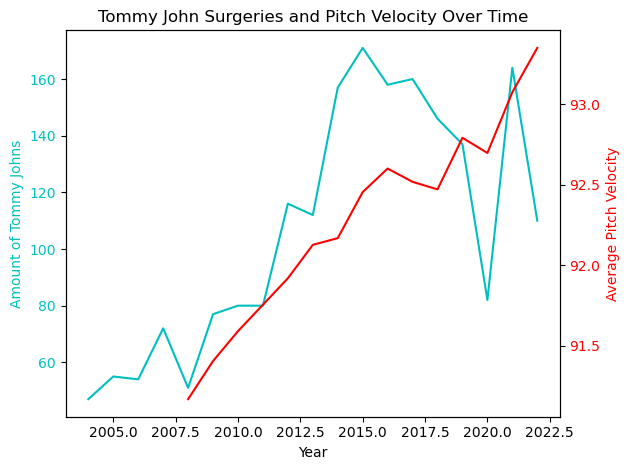

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Year"])
tommy_johns = tommy_johns.dropna(how = 'all')
counts = tommy_johns['Year'].value_counts(sort = False).reset_index()
counts = counts[counts['Year'] > 2003]
counts = counts[counts['Year'] < 2023]

pitch_velocity = pd.read_csv('pitch_velocity_1.csv', usecols = ["player_name", "velocity", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('pitch_velocity_' + str(i) + '.csv', usecols = ["player_name", "velocity", "year"])
    pitch_velocity = pd.concat([pitch_velocity, temp_pd], ignore_index = True)

pitch_velocity = pitch_velocity[pitch_velocity['year'] < 2023]

pitch_velocity2 = pitch_velocity.groupby(['year'], as_index = False)[['velocity']].mean()

fig, ax1 = plt.subplots()

ax1.plot(counts['Year'], counts['count'], color='c', label='Value1')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount of Tommy Johns', color='c')
ax1.tick_params(axis='y', labelcolor='c')

ax2 = ax1.twinx()
ax2.plot(pitch_velocity2['year'], pitch_velocity2['velocity'], color='r', label='Value2')
ax2.set_ylabel('Average Pitch Velocity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Tommy John Surgeries and Pitch Velocity Over Time')
fig.tight_layout()

plt.show()

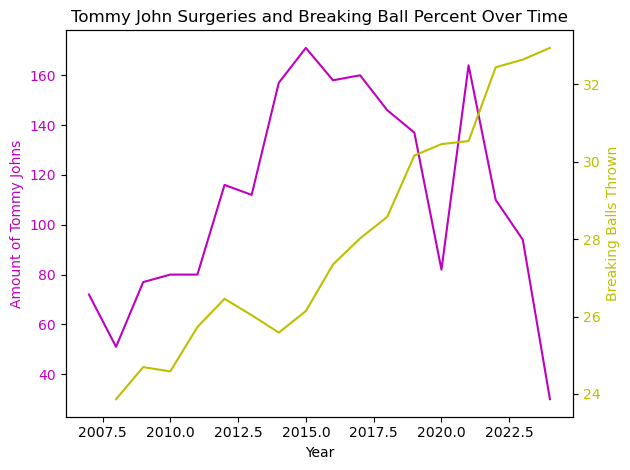

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

tommy_johns = pd.read_csv('Tommy_John_Surgery_List.csv', skiprows = 1, usecols = ["Year"])
tommy_johns = tommy_johns.dropna(how = 'all')
counts = tommy_johns['Year'].value_counts(sort = False).reset_index()
counts = counts[counts['Year'] > 2006]

spin_rate = pd.read_csv('spin_rate_1.csv', usecols = ["player_name", "pitch_percent", "year"])

for i in range(2, 7):
    temp_pd = pd.read_csv('spin_rate_' + str(i) + '.csv', usecols = ["player_name", "pitch_percent", "year"])
    spin_rate = pd.concat([spin_rate, temp_pd], ignore_index = True)

spin_rate2 = spin_rate.groupby(['year'], as_index = False)[['pitch_percent']].mean()

fig, ax1 = plt.subplots()

ax1.plot(counts['Year'], counts['count'], color='m', label='Value1')
ax1.set_xlabel('Year')
ax1.set_ylabel('Amount of Tommy Johns', color='m')
ax1.tick_params(axis='y', labelcolor='m')

ax2 = ax1.twinx()
ax2.plot(spin_rate2['year'], spin_rate2['pitch_percent'], color='y', label='Value2')
ax2.set_ylabel('Breaking Balls Thrown', color='y')
ax2.tick_params(axis='y', labelcolor='y')

plt.title('Tommy John Surgeries and Breaking Ball Percent Over Time')
fig.tight_layout()

plt.show()